In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
project_path = "/content/drive/My Drive/Colab Notebooks/CS439_Final_Project/data"
print(os.listdir(project_path))


['test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [ ]:
import pandas as pd

train_transaction_path = os.path.join(project_path, "train_transaction.csv")
train_identity_path    = os.path.join(project_path, "train_identity.csv")

# Load CSVs (low_memory=False avoids funky dtype warnings)
train_transaction = pd.read_csv(train_transaction_path, low_memory=False)
train_identity    = pd.read_csv(train_identity_path, low_memory=False)

print("train_transaction shape:", train_transaction.shape)
print("train_identity shape:", train_identity.shape)


train_transaction shape: (590540, 394)
train_identity shape: (144233, 41)


In [ ]:
# Merge on TransactionID
df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print("Merged dataframe shape:", df.shape)
df.head()


Merged dataframe shape: (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
# --- Basic Cleaning ---

# 1. Drop any exact duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Dropped {before - after} duplicate rows")

# 2. Convert TransactionDT to datetime for time-based analysis
# This dataset uses seconds from a reference start — convert roughly to days
df['TransactionDT_days'] = df['TransactionDT'] / (24 * 60 * 60)

# 3. Check missing data %
missing = df.isnull().mean().sort_values(ascending=False)
print("Top 10 columns with missing data:")
print(missing.head(10))


Dropped 0 duplicate rows
Top 10 columns with missing data:
id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

plots_path = "/content/drive/My Drive/Colab Notebooks/CS439_Final_Project/plots"
os.makedirs(plots_path, exist_ok=True)
plots_path


'/content/drive/My Drive/Colab Notebooks/CS439_Final_Project/plots'

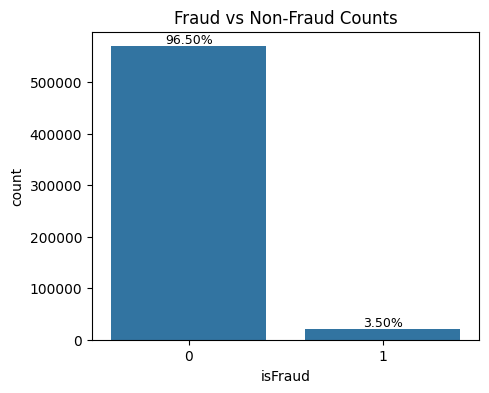

,proportion
isFraud,
0,0.96501
1,0.03499


In [ ]:
# Class imbalance plot
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='isFraud', data=df)
plt.title('Fraud vs Non-Fraud Counts')

total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    perc = 100 * count / total
    ax.annotate(f'{perc:.2f}%',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)

plt.savefig(os.path.join(plots_path, "fraud_class_imbalance.png"),
            bbox_inches='tight')
plt.show()

df['isFraud'].value_counts(normalize=True)


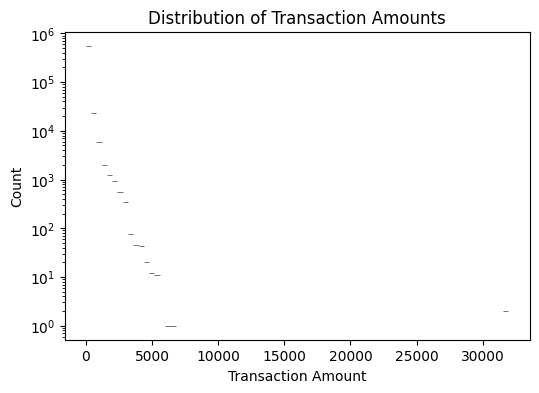

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(df['TransactionAmt'], bins=80, log_scale=(False, True))
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.title('Distribution of Transaction Amounts')
plt.savefig(os.path.join(plots_path, "transaction_amount_distribution.png"),
            bbox_inches='tight')
plt.show()


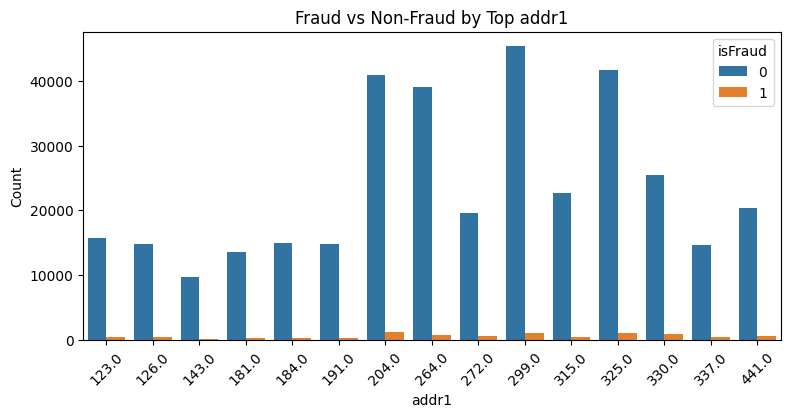

In [ ]:
top_addr1 = df['addr1'].value_counts().head(15).index
subset = df[df['addr1'].isin(top_addr1)]

plt.figure(figsize=(9, 4))
sns.countplot(data=subset, x='addr1', hue='isFraud')
plt.title('Fraud vs Non-Fraud by Top addr1')
plt.xlabel('addr1')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='isFraud')
plt.savefig(os.path.join(plots_path, "fraud_by_addr1_top15.png"),
            bbox_inches='tight')
plt.show()


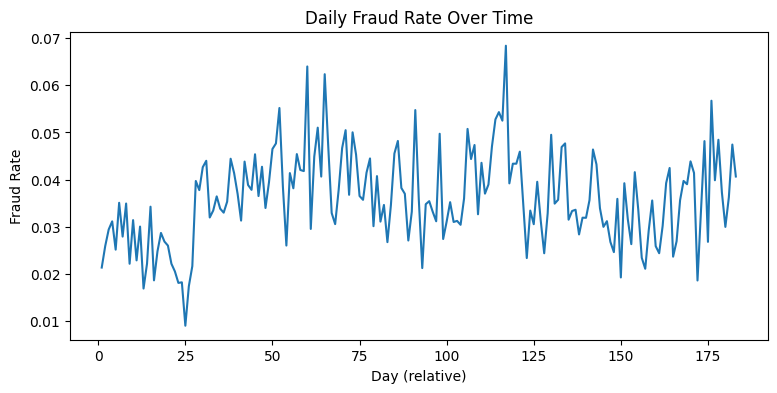

In [ ]:
daily = df.groupby(df['TransactionDT_days'].round())['isFraud'] \
          .agg(['mean', 'count']).reset_index()
daily.rename(columns={'TransactionDT_days': 'day',
                      'mean': 'fraud_rate'}, inplace=True)

plt.figure(figsize=(9, 4))
sns.lineplot(data=daily, x='day', y='fraud_rate')
plt.title('Daily Fraud Rate Over Time')
plt.xlabel('Day (relative)')
plt.ylabel('Fraud Rate')
plt.savefig(os.path.join(plots_path, "fraud_rate_over_time.png"),
            bbox_inches='tight')
plt.show()


In [ ]:
clean_path = "/content/drive/My Drive/Colab Notebooks/CS439_Final_Project/data/clean_train.parquet"
df.to_parquet(clean_path, index=False)
clean_path


'/content/drive/My Drive/Colab Notebooks/CS439_Final_Project/data/clean_train.parquet'